This Tuotorial is splitted into two main parts : the first part aims to perform the separtion between soil and plants based on pixel colors while the second part aimed to separate the crop from weed after detecting the plant. 


### Part 1: Planit soil separation

In [1]:
# Import packages 
import os
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
plt.style.use('default')
import sys
#import tensorflow 
import tensorflow as tf

# import gzip to read data 
import gzip
import glob

#details about the images: 
from skimage.io import imread
from skimage.transform import resize,rotate
from skimage.util import invert
from IPython.display import Image

#import keras elements
import keras.backend as K
import keras
from keras import layers, activations
from keras.models import Model
from keras.preprocessing.image import load_img,img_to_array
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Layer


from small_Unet import *
import json

Using TensorFlow backend.


In [3]:
# download dataset 
# This dataset comprises various images :  
# and crop/weed plant type [annotations](annotations)
#Input images : field [images](images) 
Input_images = []
path='.\Crop_weed\images'
for im in glob.glob(path+"\*.png"):
    Input_images.append(im.split('\\')[3])
    
    
# vegetation segmentation [masks](masks)       
Masks = []
path1='.\Crop_weed\masks'
for im in glob.glob(path1+"\*.png"):
    Masks.append(im.split('\\')[3])
    


# crop/weed plant type [annotations](annotations)   
annotations= []
path2='.\Crop_weed\Annotations'
for im1 in glob.glob(path2+"\*.png"):
     annotations.append(im1.split('\\')[3])
    

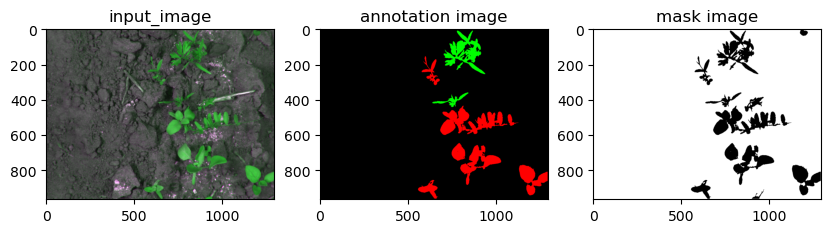

In [4]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("input_image")
plt.imshow(imread(path+"/"+Input_images[2]))
plt.subplot(1,3,2)
plt.title("annotation image")
plt.imshow(imread(path2+"/"+annotations[2]))
plt.subplot(1,3,3)
plt.title("mask image")
plt.imshow(imread(path1+"/"+Masks[2]),cmap="gray")
plt.show()

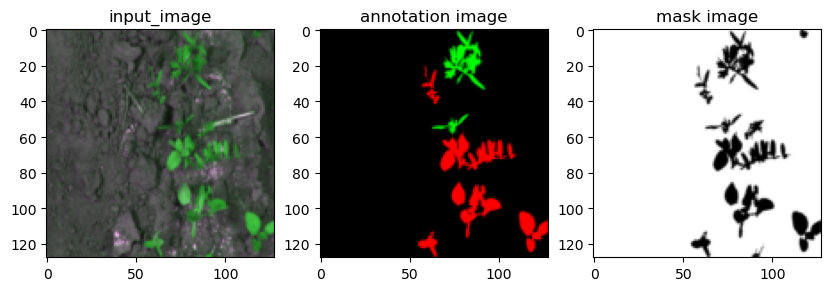

In [5]:
#for training speed, will resize it to 128, 128 
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("input_image")
plt.imshow(resize(imread(path+"/"+Input_images[2]),(128,128)))
plt.subplot(1,3,2)
plt.title("annotation image")
plt.imshow(resize(imread(path2+"/"+annotations[2]),(128,128)))
plt.subplot(1,3,3)
plt.title("mask image")
plt.imshow(resize(imread(path1+"/"+Masks[2]),(128,128)),cmap="gray")
plt.show()

## 1) Region Segmentation (plant region isolation)
Separate the soil from plants : green color from the rest of colors 

### 1.1- Model design 

In [6]:
# Model definition in the module Small_Unet.py 

In [7]:
K.clear_session()



model = small_Unet(labels=1)  


#https://stackoverflow.com/questions/49785133/keras-dice-coefficient-loss-function-is-negative-and-increasing-with-epochs
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true) # to be flat [0,0,0....]
    y_pred = K.flatten(y_pred) # to be flat 
    intersection = K.sum(y_true * y_pred)
    return (2.0 * intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


model.compile(loss=dice_coef_loss,optimizer="rmsprop")

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_2[0][0]                   
____________________________________________________________________________________________

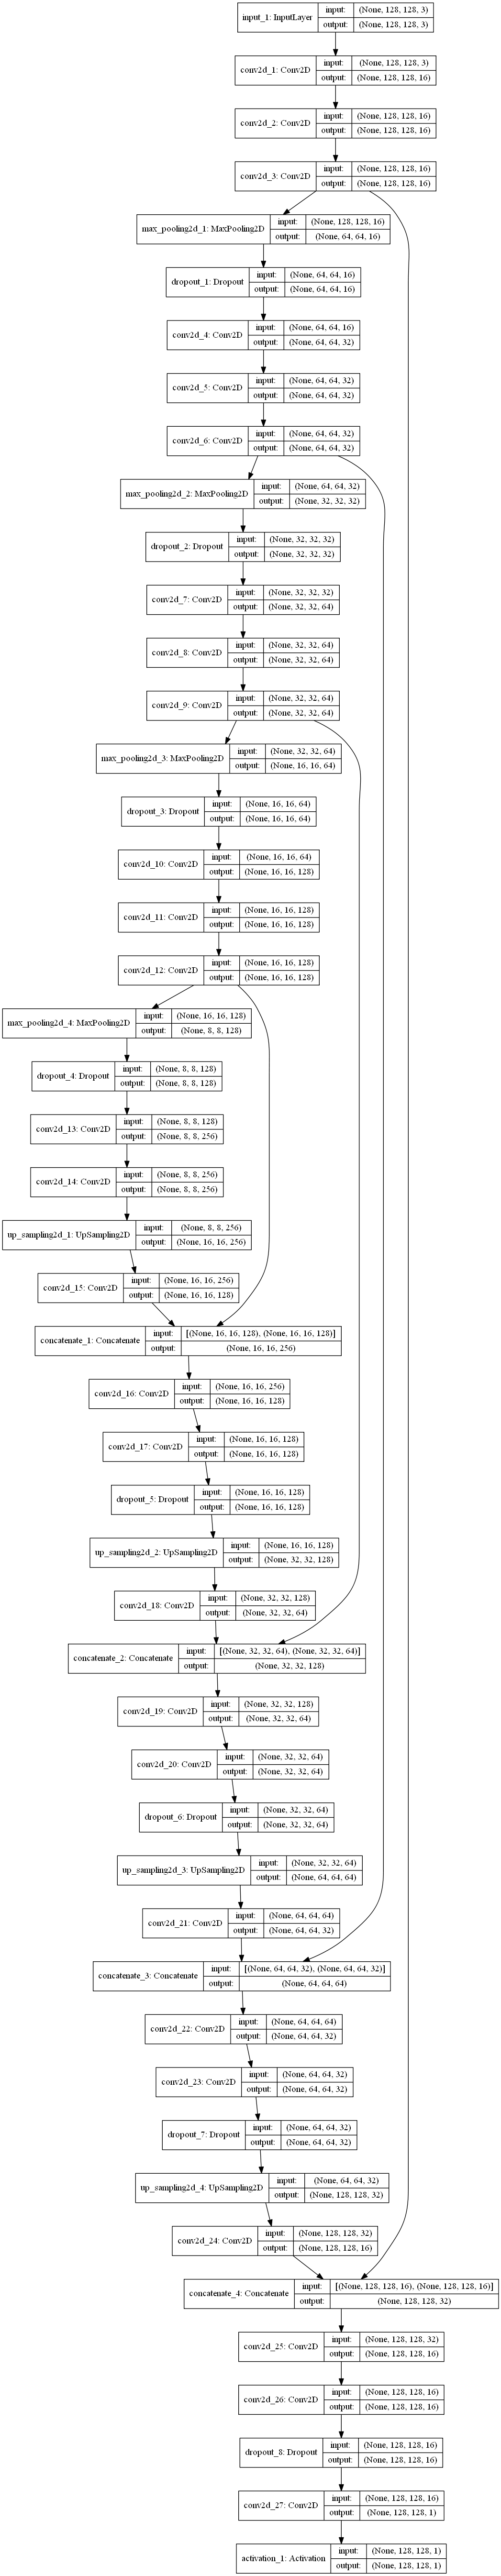

In [9]:
#alternative visualization of model structure
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

Image("model_plot.png")

### 1.2- Data preparation

In [10]:
files=Input_images+Masks+annotations
#print(sorted(files))

In [11]:
with open('.//split_train_test.json') as data:
  datasets = json.load(data)

In [12]:
# %pwd # knowing our current directory 

In [13]:
Train_data=datasets['train'] 
Test_data=datasets['test'] 

print("train_data is:",Train_data)
print("test_data is:",Train_data)

train_data is: [2, 5, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59]
test_data is: [2, 5, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59]


In [14]:
#read image into memory

train_x = []
train_y = []
test_x = []
test_y = []

for number in Train_data:
    img = load_img(path+'\\'+ str(number).zfill(3)+"_image.png" ,target_size=(128,128))
    img = img_to_array(img)/255
    train_x.append(img)
    
    img1 = load_img(path1+'\\'+ str(number).zfill(3)+"_mask.png" ,target_size=(128,128),color_mode="grayscale")
    img1 = img_to_array(img1,dtype="uint8")  
    img1 = invert(img1)/255.
    train_y.append(img1)
    
for number in Test_data:
    img = load_img(path+'\\'+ str(number).zfill(3)+"_image.png" ,target_size=(128,128))
    img = img_to_array(img)/255
    test_x.append(img)
    
    img1 = load_img(path1+'\\'+ str(number).zfill(3)+"_mask.png" ,target_size=(128,128),color_mode="grayscale")
    img1 = img_to_array(img1,dtype="uint8") 
    img1 = invert(img1)/255.
    test_y.append(img1)

In [15]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)


#check shape
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(40, 128, 128, 3)
(40, 128, 128, 1)
(21, 128, 128, 3)
(21, 128, 128, 1)


### 1.3-Model training 

In [16]:
#note, due to no augmentation and the number of datasize, the loss does not converge sometime.
#in such case, reinitialize and retrain the model.
history = model.fit(train_x, train_y, batch_size=10, epochs=150,verbose=1,validation_data=(test_x,test_y))


Train on 40 samples, validate on 21 samples
Epoch 1/150
40/40 [==============================] - 11s 273ms/step - loss: 0.8573 - val_loss: 0.8479
Epoch 2/150
40/40 [==============================] - 9s 228ms/step - loss: 0.8300 - val_loss: 0.7633
Epoch 3/150
40/40 [==============================] - 9s 216ms/step - loss: 0.7913 - val_loss: 0.5784
Epoch 4/150
40/40 [==============================] - 9s 217ms/step - loss: 0.6599 - val_loss: 0.4666
Epoch 5/150
40/40 [==============================] - 9s 216ms/step - loss: 0.5026 - val_loss: 0.4824
Epoch 6/150
40/40 [==============================] - 9s 217ms/step - loss: 0.4339 - val_loss: 0.2802
Epoch 7/150
40/40 [==============================] - 9s 216ms/step - loss: 0.3274 - val_loss: 0.3976
Epoch 8/150
40/40 [==============================] - 9s 217ms/step - loss: 0.3811 - val_loss: 0.2639
Epoch 9/150
40/40 [==============================] - 9s 221ms/step - loss: 0.3018 - val_loss: 0.2581
Epoch 10/150
40/40 [=========================

### 1.4- Model deployment

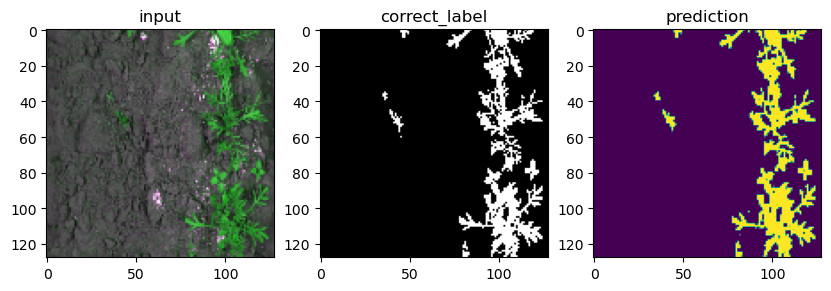

In [17]:
# change the value of n below to see different images in the test dataset
#n should be smaller than 20
n =10

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("input")
plt.imshow(test_x[n])

plt.subplot(1,3,2)
plt.title("correct_label")
plt.imshow(test_y[n,:,:,0],cmap="gray")


prediction = model.predict(test_x[n:n+1])
#prediction shape will be (1,128,128,1)

plt.subplot(1,3,3)
plt.title("prediction")
plt.imshow(prediction[0,:,:,0])